In [ ]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from zipfile import ZipFile
file_name = "/content/archive (17).zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
train_data_path = '/content/Training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
train_df

,filepaths,label
0,/content/Training/glioma/Tr-gl_0353.jpg,glioma
1,/content/Training/glioma/Tr-gl_0923.jpg,glioma
2,/content/Training/glioma/Tr-gl_0135.jpg,glioma
3,/content/Training/glioma/Tr-gl_0822.jpg,glioma
4,/content/Training/glioma/Tr-gl_0263.jpg,glioma
...,...,...
5707,/content/Training/meningioma/Tr-me_0125.jpg,meningioma
5708,/content/Training/meningioma/Tr-me_1184.jpg,meningioma
5709,/content/Training/meningioma/Tr-me_0065.jpg,meningioma
5710,/content/Training/meningioma/Tr-me_0380.jpg,meningioma


In [ ]:
test_data_path = '/content/Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)



In [ ]:
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
test_df

,filepaths,label
0,/content/Testing/glioma/Te-gl_0046.jpg,glioma
1,/content/Testing/glioma/Te-gl_0245.jpg,glioma
2,/content/Testing/glioma/Te-gl_0027.jpg,glioma
3,/content/Testing/glioma/Te-gl_0125.jpg,glioma
4,/content/Testing/glioma/Te-gl_0209.jpg,glioma
...,...,...
1306,/content/Testing/meningioma/Te-me_0156.jpg,meningioma
1307,/content/Testing/meningioma/Te-me_0231.jpg,meningioma
1308,/content/Testing/meningioma/Te-me_0026.jpg,meningioma
1309,/content/Testing/meningioma/Te-me_0222.jpg,meningioma


In [ ]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

In [ ]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


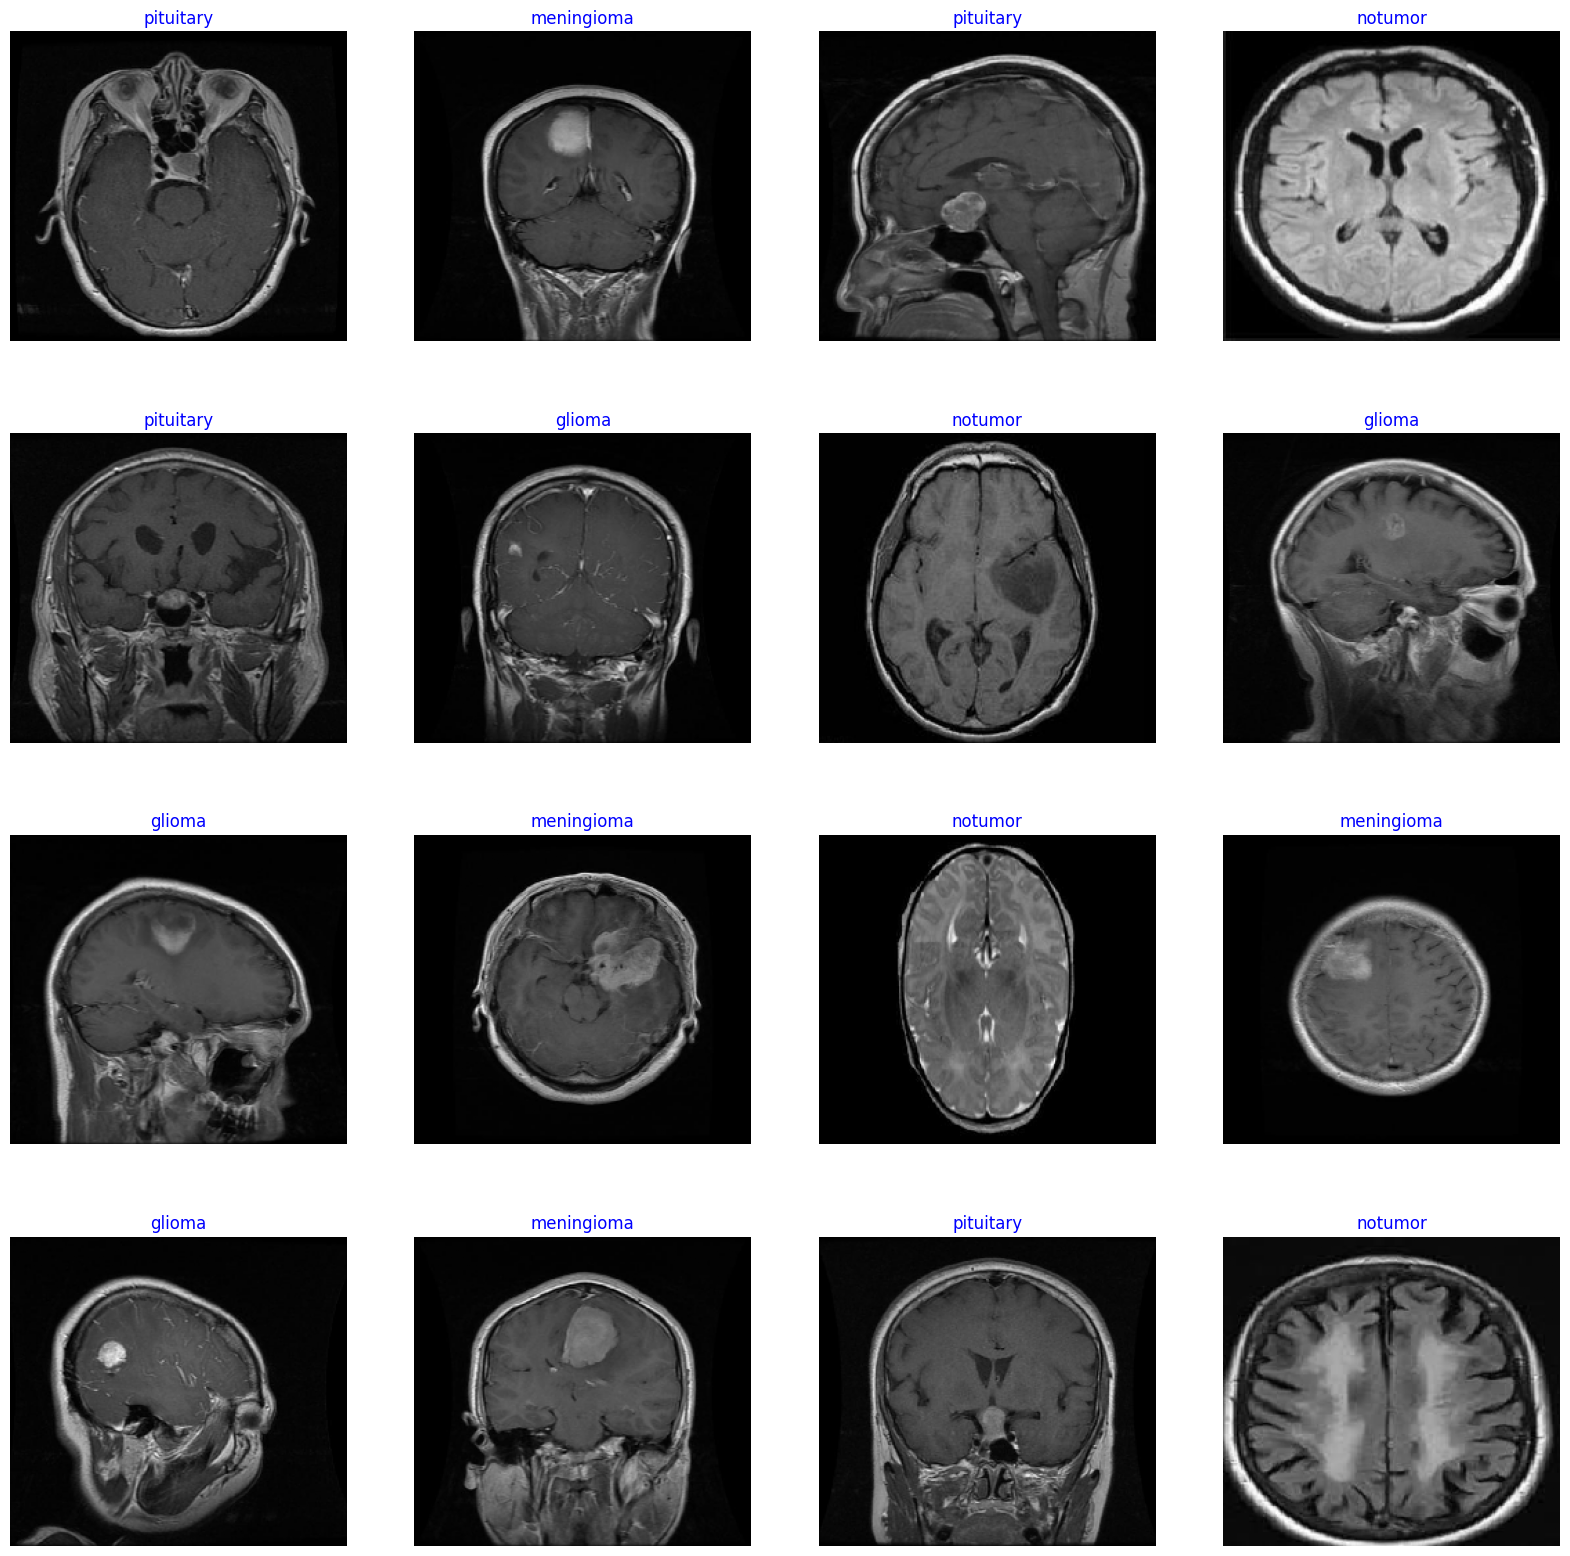

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [ ]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

43941136/43941136 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

In [ ]:
Epochs = 10

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/10
357/357 [==============================] - 172s 306ms/step - loss: 5.8584 - accuracy: 0.8626 - val_loss: 3.9122 - val_accuracy: 0.9344
Epoch 2/10
357/357 [==============================] - 105s 293ms/step - loss: 2.8453 - accuracy: 0.9547 - val_loss: 1.9383 - val_accuracy: 0.9832
Epoch 3/10
357/357 [==============================] - 105s 295ms/step - loss: 1.4704 - accuracy: 0.9704 - val_loss: 1.0085 - val_accuracy: 0.9847
Epoch 4/10
357/357 [==============================] - 106s 296ms/step - loss: 0.7783 - accuracy: 0.9793 - val_loss: 0.5685 - val_accuracy: 0.9786
Epoch 5/10
357/357 [==============================] - 106s 296ms/step - loss: 0.4490 - accuracy: 0.9834 - val_loss: 0.3856 - val_accuracy: 0.9695
Epoch 6/10
357/357 [==============================] - 105s 294ms/step - loss: 0.2948 - accuracy: 0.9893 - val_loss: 0.2309 - val_accuracy: 0.9939
Epoch 7/10
357/357 [==============================] - 106s 296ms/step - loss: 0.2278 - accuracy: 0.9907 - val_loss: 0.1696 -

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

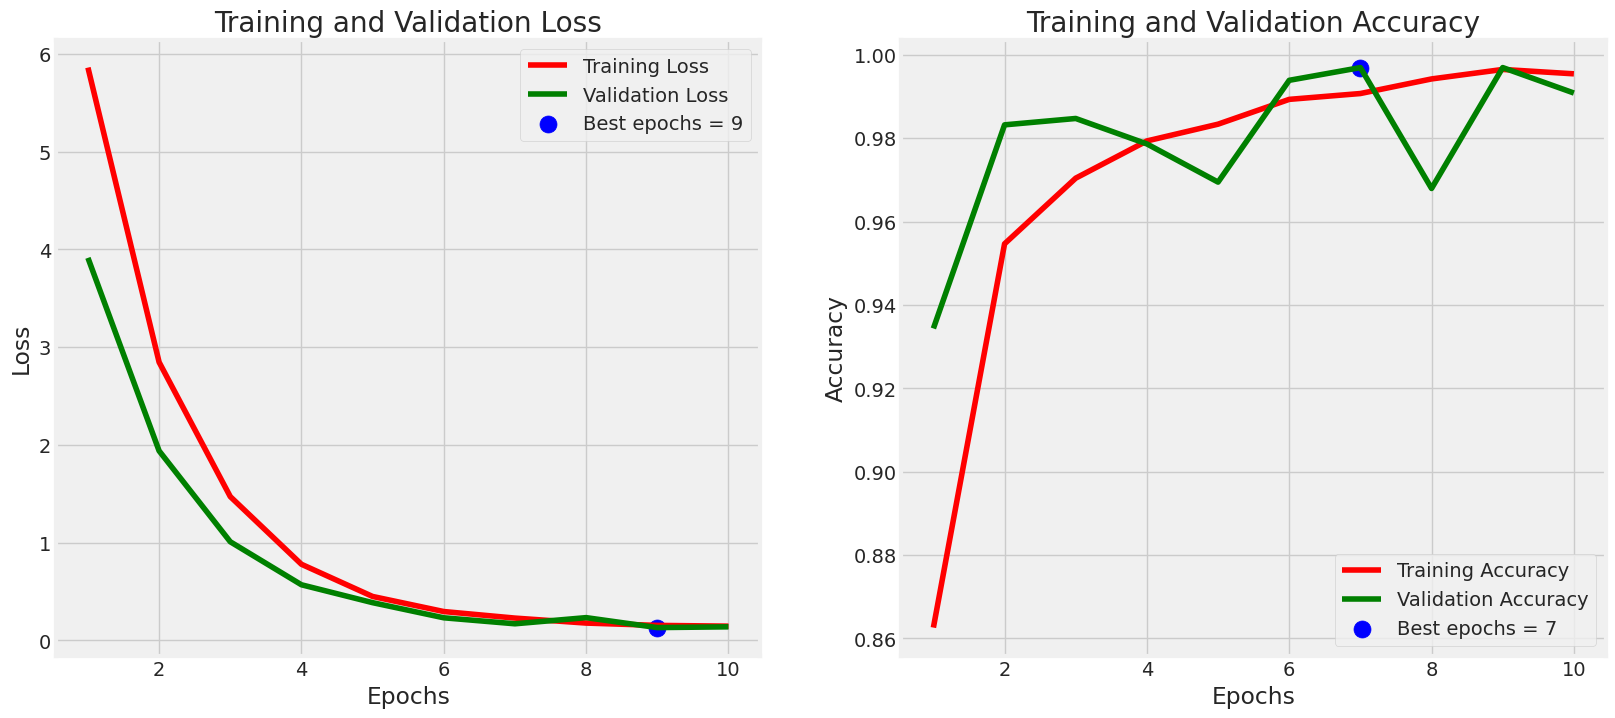

In [ ]:
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


16/16 [==============================] - 1s 68ms/step - loss: 0.1477 - accuracy: 0.9922
Train Loss:  0.11737138777971268
Train Accuracy:  1.0
--------------------
Validation Loss:  0.15379217267036438
Validation Accuracy:  0.984375
--------------------
Test Loss:  0.14771457016468048
Test Accuracy:  0.9921875


In [ ]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

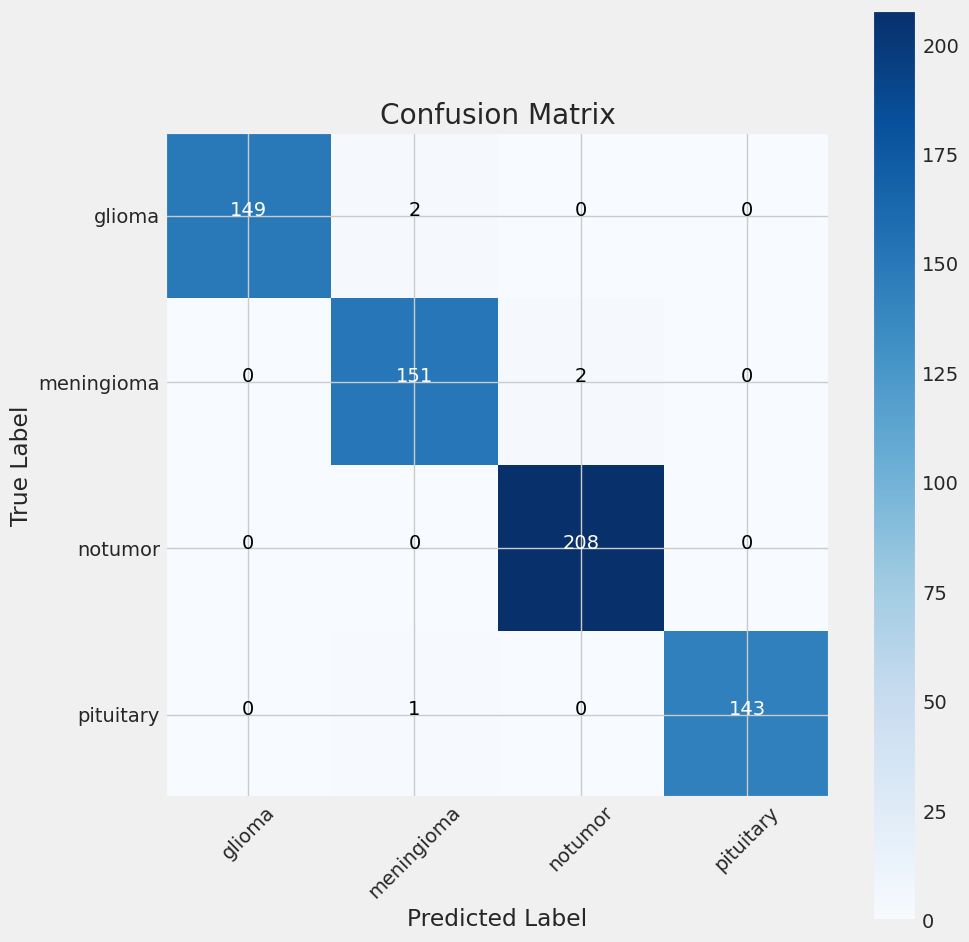

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       151
  meningioma       0.98      0.99      0.98       153
     notumor       0.99      1.00      1.00       208
   pituitary       1.00      0.99      1.00       144

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



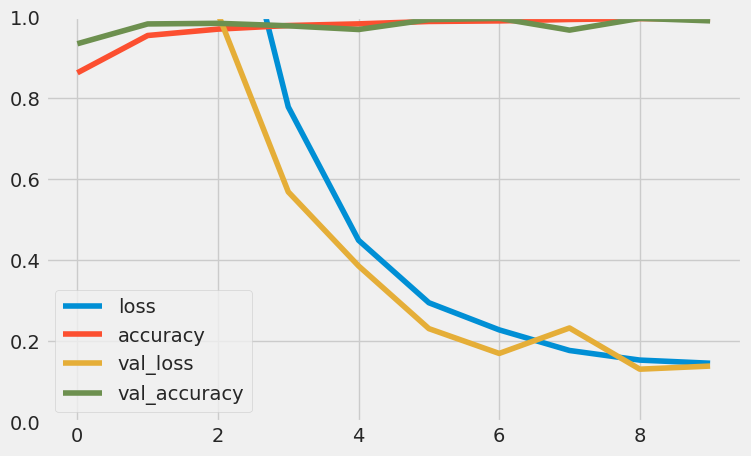

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential()

# Convolutional Layers
model.add(layers.Conv2D(64, (7, 7), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (7, 7), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (7, 7), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (7, 7), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (7, 7), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (7, 7), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten Layer
model.add(layers.Flatten())

# Fully Connected Layers
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(4, activation='softmax'))  # Adjust the output size based on your problem

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Adjust based on your problem
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     401536    
                                                                 
 batch_normalization_2 (Bat  (None, 112, 112, 128)     512       
 chNormalization)                                                
                                                      

In [ ]:
Epochs = 10

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/10
357/357 [==============================] - 85s 202ms/step - loss: 1.3738 - accuracy: 0.6444 - val_loss: 0.7323 - val_accuracy: 0.7359
Epoch 2/10
357/357 [==============================] - 69s 192ms/step - loss: 0.6546 - accuracy: 0.7586 - val_loss: 0.7425 - val_accuracy: 0.6809
Epoch 3/10
357/357 [==============================] - 69s 193ms/step - loss: 0.5033 - accuracy: 0.8132 - val_loss: 0.6556 - val_accuracy: 0.7450
Epoch 4/10
357/357 [==============================] - 70s 196ms/step - loss: 0.4277 - accuracy: 0.8458 - val_loss: 0.4351 - val_accuracy: 0.8168
Epoch 5/10
357/357 [==============================] - 70s 196ms/step - loss: 0.3762 - accuracy: 0.8531 - val_loss: 0.6683 - val_accuracy: 0.7176
Epoch 6/10
357/357 [==============================] - 70s 196ms/step - loss: 0.2922 - accuracy: 0.8965 - val_loss: 0.6118 - val_accuracy: 0.7847
Epoch 7/10
357/357 [==============================] - 70s 197ms/step - loss: 0.2586 - accuracy: 0.9119 - val_loss: 0.3784 - val_ac

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

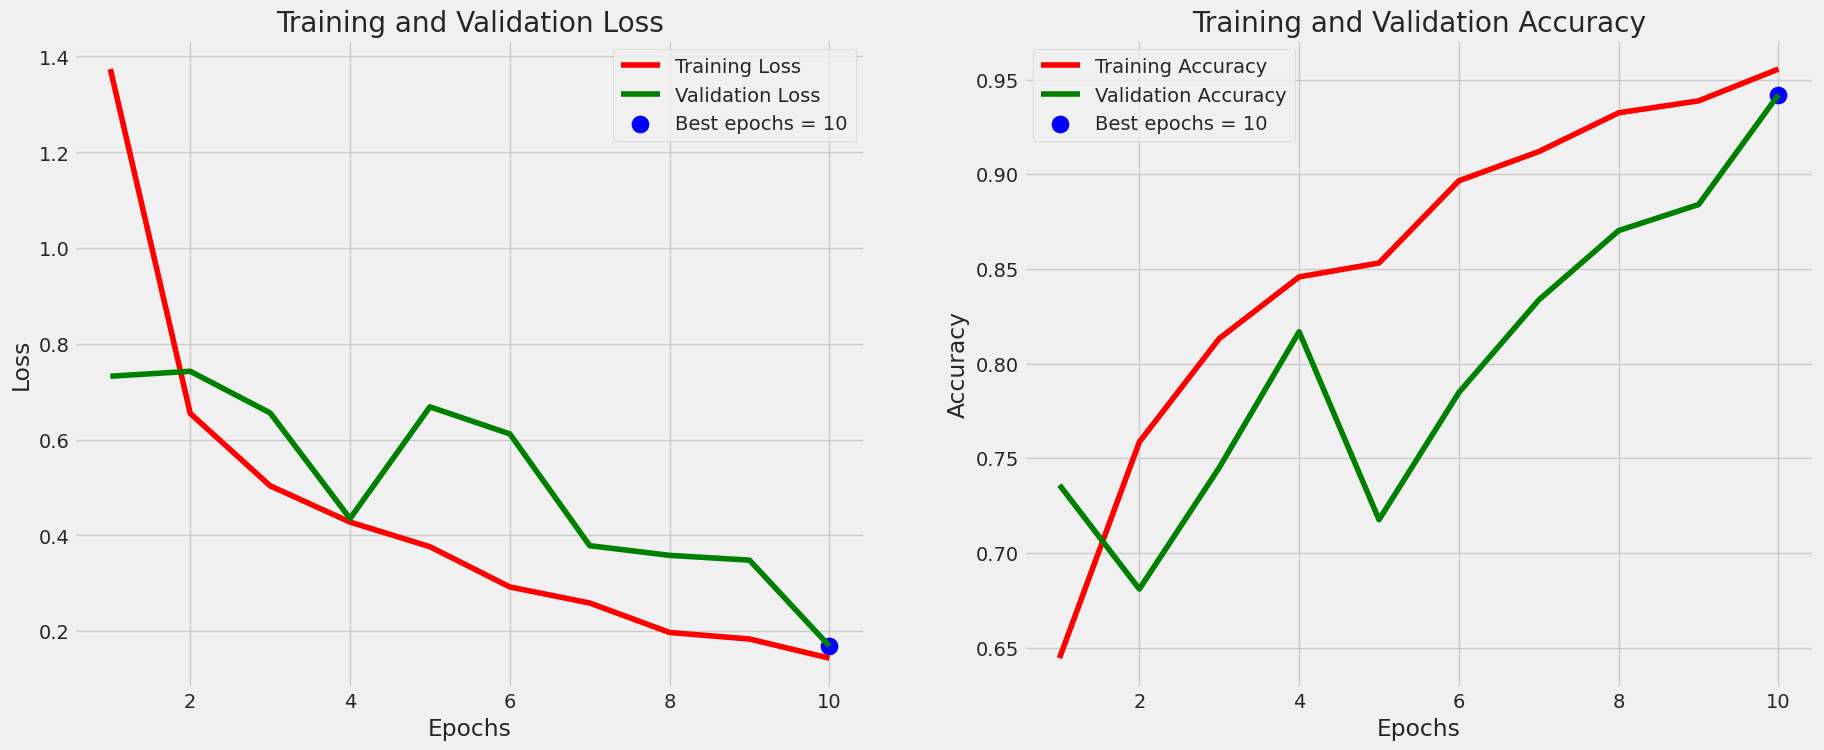

In [ ]:
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 1s 50ms/step - loss: 0.1886 - accuracy: 0.9375
Train Loss:  0.09803704917430878
Train Accuracy:  0.95703125
--------------------
Validation Loss:  0.16337595880031586
Validation Accuracy:  0.94921875
--------------------
Test Loss:  0.18856514990329742
Test Accuracy:  0.9375


In [ ]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

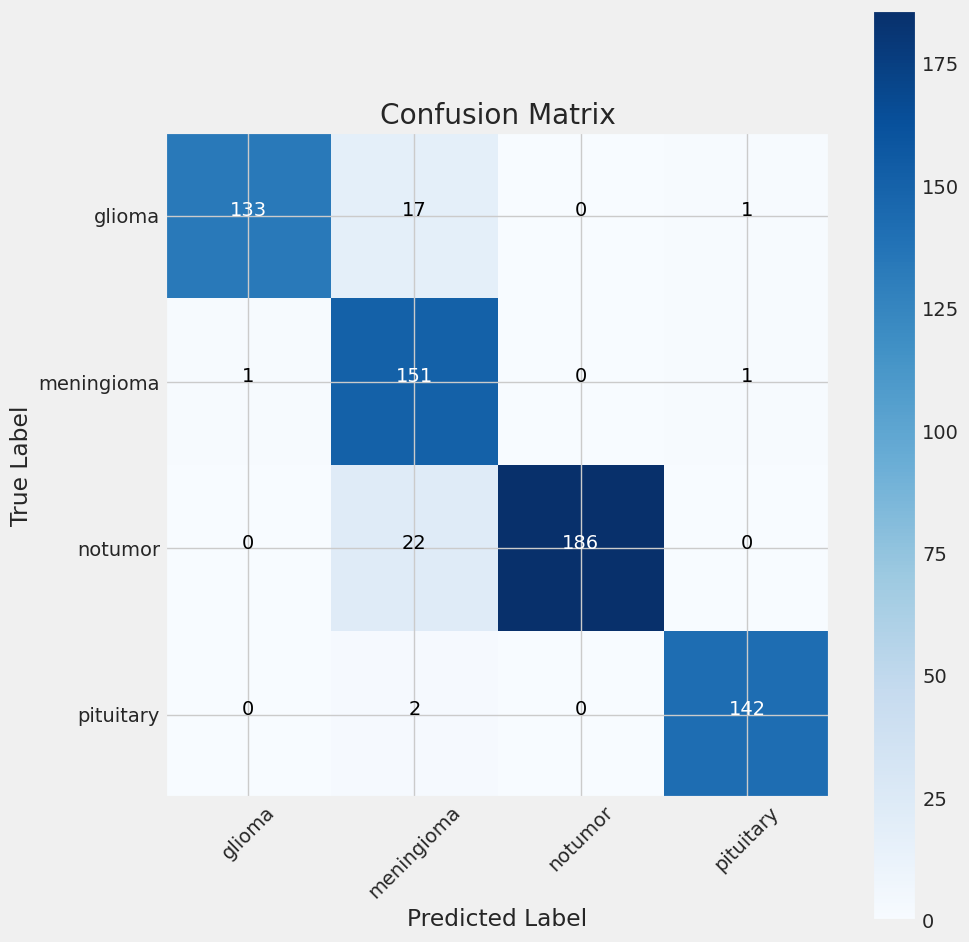

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.99      0.88      0.93       151
  meningioma       0.79      0.99      0.88       153
     notumor       1.00      0.89      0.94       208
   pituitary       0.99      0.99      0.99       144

    accuracy                           0.93       656
   macro avg       0.94      0.94      0.93       656
weighted avg       0.95      0.93      0.93       656

